# Scenario Builder

In [1]:
using Pkg;
Pkg.activate("..")

  Activating project at `~/Documents/repos/GatekeeperFormationFlight.jl/examples`


In [2]:
using Revise
using GatekeeperFormationFlight

In [3]:
using StaticArrays
using YAML
using Plots
using Polynomials

In [4]:
include("./file_util.jl")
include("../3d_example_utils.jl")
include("./demo_util.jl")

Main.DemoUtil

## Create the Scenario

### Create the Obstacles

In [14]:
# Empty Vector of Obstacles
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()

GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[]

In [15]:
gate_1 = Cylinder(0.0, 0.0, 0.35)
push!(obstacles, obs_1)

# obs_2 = Sphere(2.5, 1.5, 1.5, 0.5)
# push!(obstacles, obs_2)

1-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 FPVGate{Float64}([0.0, 0.0, 0.5])

In [16]:
obstacles_dict = [FileUtil.obstacle_to_dict(obs) for obs in obstacles]

1-element Vector{Dict{String, Any}}:
 Dict("position" => [0.0, 0.0, 0.5], "type" => "FPVGate")

### Create the Gatekeeper Coefficients Object

In [17]:
# Create desired object using kwarg constructor
coeffs = GatekeeperCoefficients(
    switch_step_size = 0.25,
    reconnection_step_size = 0.125,
    max_Ts_horizon = 10.0,
    integration_max_step_size = 0.05,
    integration_step_size = 0.01,
    collision_check_step_size = 0.05
)

# Convert to dictionary with symbol keys
coeffs_dict = Dict(fieldnames(GatekeeperCoefficients) .=> getfield.(Ref(coeffs), fieldnames(GatekeeperCoefficients)))

Dict{Symbol, Float64} with 6 entries:
  :reconnection_step_size    => 0.125
  :max_Ts_horizon            => 10.0
  :integration_step_size     => 0.01
  :collision_check_step_size => 0.05
  :switch_step_size          => 0.25
  :integration_max_step_size => 0.05

### Create the Agent Settings

In [18]:
agent_settings = DemoUtil.AgentSettings(
    v_min = 0.8,
    v_max = 1.0,
    x_padding = 0.1,
    agent_radius = 0.15,
    turn_radius = 1.,
    pitch_limits = SVector(-pi / 4, pi / 4)
)

agent_settings_dict = Dict(fieldnames(DemoUtil.AgentSettings) .=> getfield.(Ref(agent_settings), fieldnames(DemoUtil.AgentSettings)))

Dict{Symbol, Any} with 6 entries:
  :turn_radius  => 1.0
  :pitch_limits => [-0.785398, 0.785398]
  :v_min        => 0.8
  :v_max        => 1.0
  :x_padding    => 0.1
  :agent_radius => 0.15

### Set Agent Offsets

In [19]:
sim_agents = Vector{DemoUtil.SimAgent}()

Main.DemoUtil.SimAgent[]

In [20]:
agent1 = DemoUtil.SimAgent(
    id = 1,
    offset = SVector(0.0, 0.0, 0.0, 0.0, 0.0)
)
agent2 = DemoUtil.SimAgent(
    id = 2,
    offset = SVector(-0.3, -0.6, 0.0, 0.0, 0.0)
)
agent3 = DemoUtil.SimAgent(
    id = 3,
    offset = SVector(-0.3, 0.6, 0.0, 0.0, 0.0)
)

push!(sim_agents, agent1)
push!(sim_agents, agent2)
push!(sim_agents, agent3)

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [-0.3, -0.6, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [-0.3, 0.6, 0.0, 0.0, 0.0])

In [21]:
sim_agents_out = [Dict(fieldnames(DemoUtil.SimAgent) .=> getfield.(Ref(sim_agent), fieldnames(DemoUtil.SimAgent))) for sim_agent in sim_agents]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:offset => [0.0, 0.0, 0.0, 0.0, 0.0], :id => 1)
 Dict(:offset => [-0.3, -0.6, 0.0, 0.0, 0.0], :id => 2)
 Dict(:offset => [-0.3, 0.6, 0.0, 0.0, 0.0], :id => 3)

### Create the Scenario

In [22]:
scenario = DemoUtil.SimScenario(
    name = "gate_scenario_1",
    start_pose = SVector(-1.8, -1.2, 0.5, 0.0, 0.0),
    goal_pose = SVector(1.8, 1.2, 1.5, 0.0, 0.0),
    domain_min = SVector(-3.0, -2.0, 0.0), 
    domain_max = SVector(2.0, 2.0, 2.0)
)
scenario_dict = Dict(fieldnames(DemoUtil.SimScenario) .=> getfield.(Ref(scenario), fieldnames(DemoUtil.SimScenario)))

Dict{Symbol, Any} with 5 entries:
  :start_pose => [-1.8, -1.2, 0.5, 0.0, 0.0]
  :domain_min => [-3.0, -2.0, 0.0]
  :name       => "gate_scenario_1"
  :domain_max => [2.0, 2.0, 2.0]
  :goal_pose  => [1.8, 1.2, 1.5, 0.0, 0.0]

### Write YAML

In [23]:
output_object = Dict(
    "gatekeeper_coefficients" => coeffs_dict,
    "obstacles" => obstacles_dict,
    "agent_settings" => agent_settings_dict,
    "agents" => sim_agents_out,
    "scenario" => scenario_dict
)

YAML.write_file("scenarios/$(scenario_dict[:name]).yaml", output_object)


### Plot the Scenario

In [25]:
## 2D plot showing the scenario domain, and start & goal poses w/offsets

# Extract domain and poses
domain_min = scenario.domain_min
domain_max = scenario.domain_max
start_pose = scenario.start_pose
goal_pose = scenario.goal_pose

# Agent offsets
offsets = [agent.offset for agent in sim_agents]

# Plot domain as rectangle
p = plot(; legend=false, aspect_ratio=:equal, title="Scenario Domain and Agent Poses")
plot!(p, [domain_min[1], domain_max[1], domain_max[1], domain_min[1], domain_min[1]],
         [domain_min[2], domain_min[2], domain_max[2], domain_max[2], domain_min[2]],
         seriestype=:shape, fillalpha=0.1, color=:gray, label="Domain")

# Plot start and goal poses
scatter!(p, [start_pose[1]], [start_pose[2]], color=:green, marker=:star5, markersize=8, label="Start")
scatter!(p, [goal_pose[1]], [goal_pose[2]], color=:red, marker=:star5, markersize=8, label="Goal")

# Plot agent offsets at start
for (i, offset) in enumerate(offsets)
    scatter!(p, [start_pose[1] + offset[1]], [start_pose[2] + offset[2]],
             color=:blue, marker=:circle, markersize=6, label="Agent $i Start Offset")
end

# Plot agent offsets at goal
for (i, offset) in enumerate(offsets)
    scatter!(p, [goal_pose[1] + offset[1]], [goal_pose[2] + offset[2]],
             color=:orange, marker=:circle, markersize=6, label="Agent $i Goal Offset")
end

for obs in env.obstacles
    plot!(p, PlotCircle(obs), label = false, linedwidth = 2)
end

display(p)


UndefVarError: UndefVarError: `env` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Load YAML

In [5]:
obj = YAML.load_file("scenarios/demo_scenario.yaml"; dicttype=Dict{Symbol, Any})

Dict{Symbol, Any} with 5 entries:
  :obstacles               => Dict{Symbol, Any}[Dict(:radius=>0.5, :position=>[…
  :gatekeeper_coefficients => Dict{Symbol, Any}(:reconnection_step_size=>0.125,…
  :agent_settings          => Dict{Symbol, Any}(:turn_radius=>0.5, :pitch_limit…
  :agents                  => Dict{Symbol, Any}[Dict(:offset=>[0.0, 0.0, 0.0, 0…
  :scenario                => Dict{Symbol, Any}(:start_pose=>[0.0, 0.0, 0.0, 0.…

In [6]:
coeffs_in = obj[:gatekeeper_coefficients]
gk_coeffs = GatekeeperCoefficients(; coeffs_in...)
obj[:gatekeeper_coefficients] = gk_coeffs

GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5)

In [7]:
objects_in = obj[:obstacles]
objects = [FileUtil.dict_to_obstacle(obs) for obs in objects_in]
obj[:obstacles] = objects

2-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 Cylinder{Float64}([1.5, 1.5, 0.0], 0.5)
 Sphere{Float64}([2.5, 1.5, 1.5], 0.5)

In [8]:
obj[:agent_settings] = DemoUtil.AgentSettings(; obj[:agent_settings]...)

Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483])

In [9]:
obj[:agents] = [DemoUtil.SimAgent(; agent...) for agent in obj[:agents]]

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])

In [10]:
# @show obj[:scenario]
obj[:scenario] = DemoUtil.SimScenario(; obj[:scenario]...)

Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0])

In [11]:
# sim_env = DemoUtil.SimEnvironment(; obj...)
sim_env = DemoUtil.SimEnvironment(; obj...)

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[Cylinder{Float64}([1.5, 1.5, 0.0], 0.5), Sphere{Float64}([2.5, 1.5, 1.5], 0.5)], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5), nothing, nothing, nothing, nothing, nothing)

## Testing with DemoUtil

In [23]:
include("../3d_example_utils.jl")
# include("./demo_util.jl")

Main.ExampleUtils3D

In [5]:
env = DemoUtil.load_env("scenarios/gate_scenario_2.yaml")

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("gate_scenario_2", 30.0, 0.005, [-2.4, -1.2, 0.5, 0.0, 0.0], [1.8, 1.2, 0.5, 0.0, 0.0], [-3.0, -2.0, 0.0], [2.0, 2.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.2, 0.5, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [-0.3, -0.6, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [-0.3, 0.6, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[FPVGate{Float64}([0.0, 0.0, 0.35])], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.25), nothing, nothing, nothing, nothing, nothing)

In [17]:
success = DemoUtil.solve_leader_path!(env)

true

### Plot the Solved Path

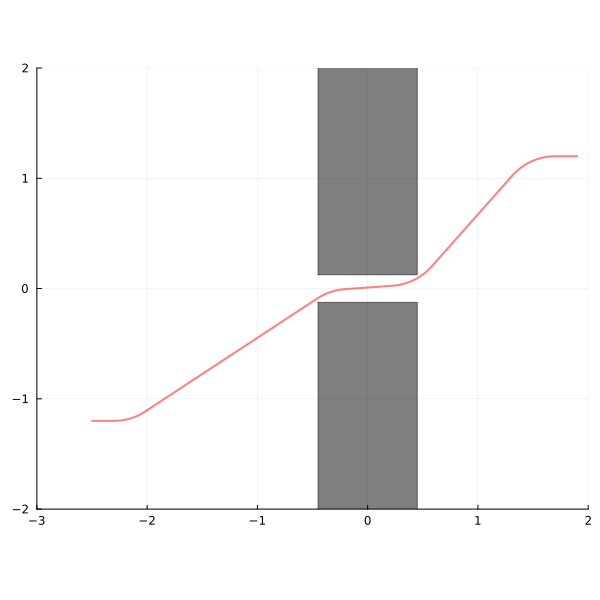

In [18]:
p = ExampleUtils3D.visualize_baseline_2d(env.obstacles, env.leader_path; dims_min=env.scenario.domain_min[1:2], dims_max=env.scenario.domain_max[1:2])

### Solve the GK Problem & Plot

In [31]:
success = DemoUtil.solve_gk_problem!(env)

      Multi-Agent Gatekeeper Simulation        
Number of agents: 3
Timespan: [0.0, 5.225561711793274]


[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 1 at x0 = [-2.4, -1.2, 0.5, 0.0, 0.0]
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 2 at x0 = [-2.6999999999999997, -1.7999999999999998, 0.5, 0.0, 0.0]
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 3 at x0 = [-2.6999999999999997, -0.6, 0.5, 0.0, 0.0]
┌ GatekeeperFormationFlight.MultiGatekeeper | Warning ] : Failed to find valid switch time. Returning nothing.
└ @ GatekeeperFormationFlight.MultiGatekeeper ~/Documents/repos/GatekeeperFormationFlight.jl/src/multi_gatekeeper.jl:268
┌ GatekeeperFormationFlight.MultiGatekeeper | Error ] : No candidate trajectory found for agent 3. Cannot proceed with simulation.
└ @ GatekeeperFormationFlight.MultiGatekeeper ~/Documents/repos/GatekeeperFormationFlight.jl/src/multi_gatekeeper.jl:80


false

### Plot the Interagent Solution

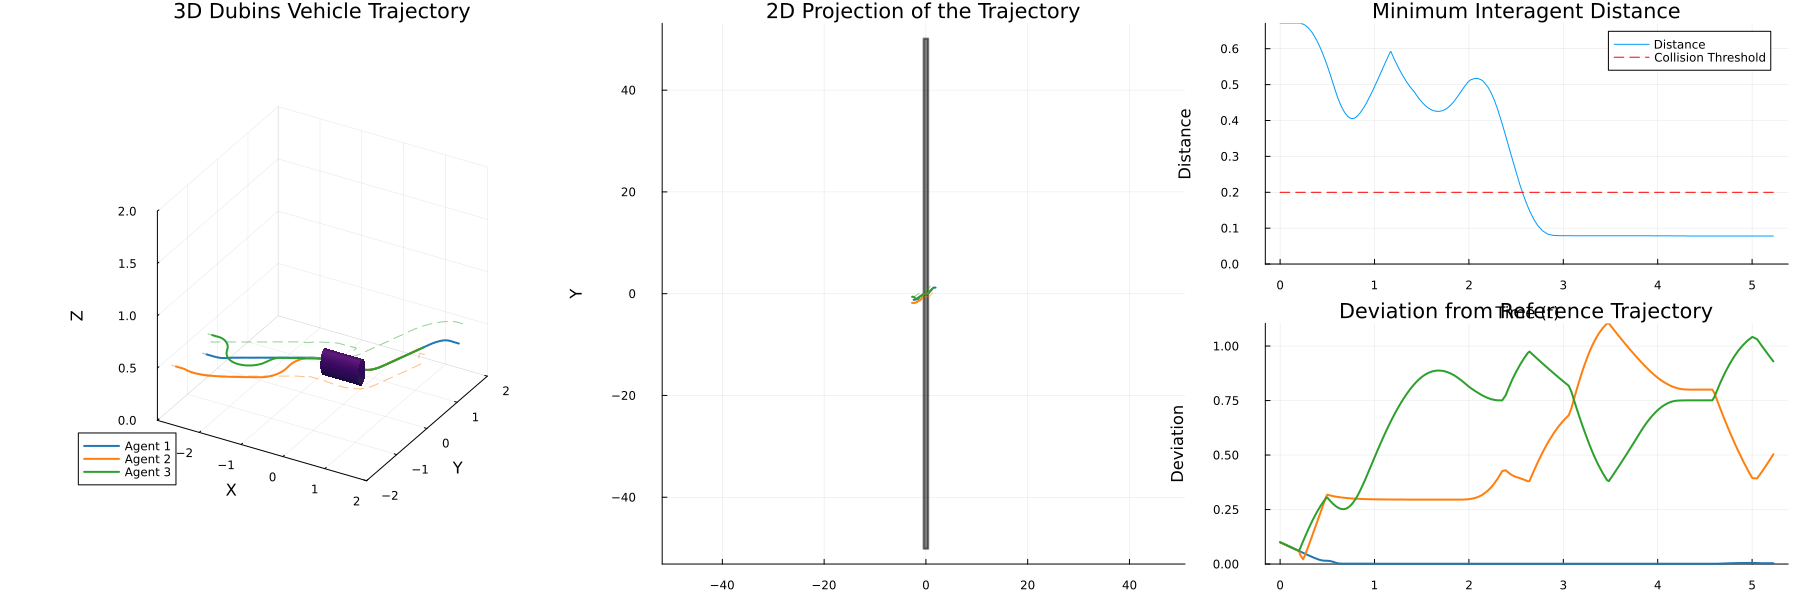

In [23]:
p1 = ExampleUtils3D.plot_interagent_solution(env.solution, env.gk; dims_min=env.scenario.domain_min, dims_max=env.scenario.domain_max)

### Animate 2D View of Solution

Animation Time: 0.0
Animation Time: 0.052783451634275495
Animation Time: 0.10556690326855099
Animation Time: 0.15835035490282648
Animation Time: 0.21113380653710198
Animation Time: 0.26391725817137746
Animation Time: 0.31670070980565296
Animation Time: 0.36948416143992846
Animation Time: 0.42226761307420396
Animation Time: 0.47505106470847946
Animation Time: 0.5278345163427549
Animation Time: 0.5806179679770305
Animation Time: 0.6334014196113059
Animation Time: 0.6861848712455815
Animation Time: 0.7389683228798569
Animation Time: 0.7917517745141325
Animation Time: 0.8445352261484079
Animation Time: 0.8973186777826834
Animation Time: 0.9501021294169589
Animation Time: 1.0028855810512345
Animation Time: 1.0556690326855098
Animation Time: 1.1084524843197854
Animation Time: 1.161235935954061
Animation Time: 1.2140193875883363
Animation Time: 1.2668028392226118
Animation Time: 1.3195862908568874
Animation Time: 1.372369742491163
Animation Time: 1.4251531941254383
Animation Time: 1.477936645

[ Plots | Info ] : Saved animation to /Users/marshallvielmetti/Documents/repos/GatekeeperFormationFlight.jl/examples/caams_demo/interagent_2d_animation_demo.gif


Plots.AnimatedGif("/Users/marshallvielmetti/Documents/repos/GatekeeperFormationFlight.jl/examples/caams_demo/interagent_2d_animation_demo.gif")
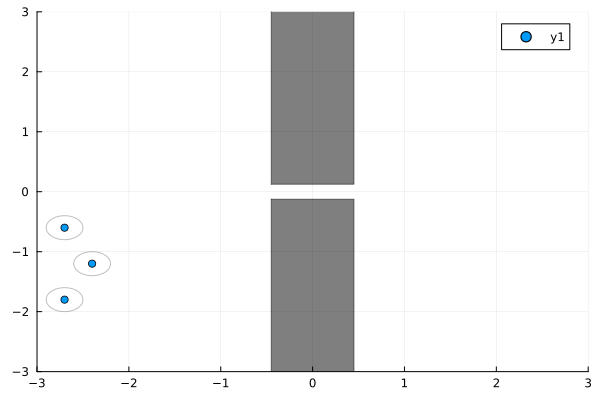

In [24]:
# include("../3d_example_utils.jl")
anim = ExampleUtils3D.animate_interagent_2d(env.solution, env.gk)
gif(anim, "interagent_2d_animation_demo.gif", fps=10)

### Write Solution to File

In [38]:
DemoUtil.write_to_file(env, "scenarios/demo_scenario_solution.csv", env.scenario.reconstruction_step_size)

Row,pos_z,time,pos_y,heading,agent_id,pos_x
,Float64,Float64,Float64,Float64,Int64,Float64
1,0.5,0.0,-1.2,0.0,1,-2.4
2,0.5,0.0,-1.8,0.0,2,-2.7
3,0.5,0.0,-0.6,0.0,3,-2.7
4,0.5,0.000956559,-1.2,0.0,1,-2.396
5,0.5,0.000956559,-1.8,0.0,2,-2.696
6,0.5,0.000956559,-0.6,0.0,3,-2.696
7,0.5,0.00191312,-1.2,0.0,1,-2.392
8,0.5,0.00191312,-1.8,0.0,2,-2.692
9,0.5,0.00191312,-0.6,0.0,3,-2.692


In [39]:
chunk_polys = DemoUtil.fit_polynomials(env.data, chunk_size=40; trajectory_time=env.scenario.reconstruction_time)

90-element Vector{Any}:
 (agent_id = 1.0, duration = 1.2626582859752666, var"x^0" = -2.399999841018861, var"x^1" = 0.13937607999336946, var"x^2" = 0.00016763631976597542, var"x^3" = -0.0008710454599530141, var"x^4" = 0.0021742575846950556, var"x^5" = -0.002793508546247732, var"x^6" = 0.0017795560956111536, var"x^7" = -0.00044472127416438794, var"y^0" = -1.2000064250834082, var"y^1" = 0.0005123268632263165, var"y^2" = -0.0070560644117315, var"y^3" = 0.03727972055489018, var"y^4" = -0.09460909691162986, var"y^5" = 0.12358968017952647, var"y^6" = -0.0800570755046449, var"y^7" = 0.020346441890621743, var"z^0" = 0.5000035981768877, var"z^1" = -0.0002877235330863207, var"z^2" = 0.003970940077471663, var"z^3" = -0.02102155087522321, var"z^4" = 0.05345340892099835, var"z^5" = -0.0699636191180347, var"z^6" = 0.04540852337079716, var"z^7" = -0.011563118380820707, var"yaw^0" = -9.451602909712945e-5, var"yaw^1" = 0.011320236428352712, var"yaw^2" = -0.19441303701489926, var"yaw^3" = 1.2216921622285

### Plot the Chunk Polynomials

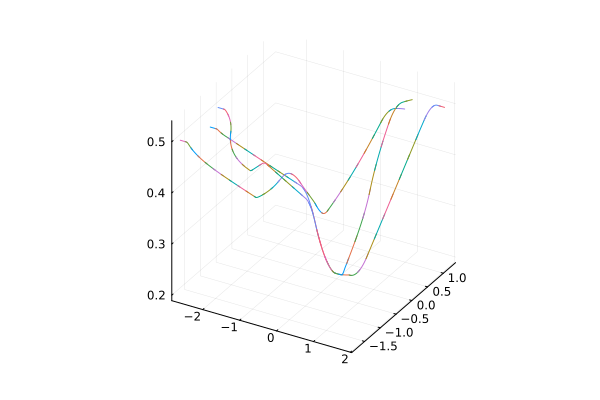

In [40]:
p = plot(legend = false)
for pnom in chunk_polys
    # reconstruct polynomial from coefficients
    px = Polynomial(values(pnom)[3:10])
    py = Polynomial(values(pnom)[11:18])
    pz = Polynomial(values(pnom)[19:26])

    plot!(
        p,
        τ -> px(τ),
        τ -> py(τ),
        τ -> pz(τ),
        0:0.01:pnom.duration,
    )
end

display(p)

### Write the Polynomials to a File

In [41]:
DemoUtil.write_polynomials_to_file(chunk_polys, "scenarios/$(env.scenario.name)_trajectories.csv")

"scenarios/gate_scenario_2_trajectories.csv"

## Testing w/FPV Gate

In [52]:
using Revise
using GatekeeperFormationFlight

In [5]:
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()
obs_1 = FPVGate(SVector(0.0, 0.0, 0.5))
push!(obstacles, obs_1)

1-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 FPVGate{Float64}([0.0, 0.0, 0.5])

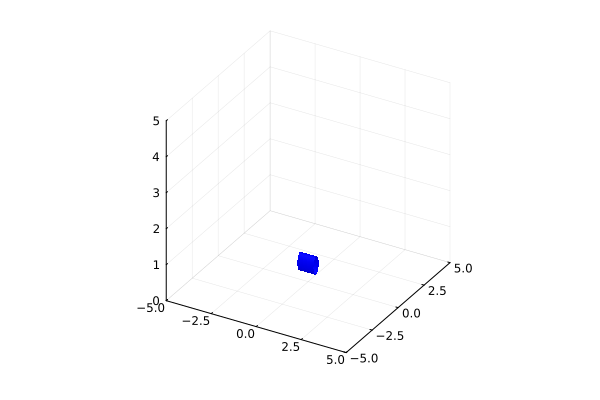

In [6]:
p = plot(obs_1, label = "FPV Gate", linewidth = 2, color = :blue)
xlims!(p, -5.0, 5.0)
ylims!(p, -5.0, 5.0)
zlims!(p, 0.0, 5.0)

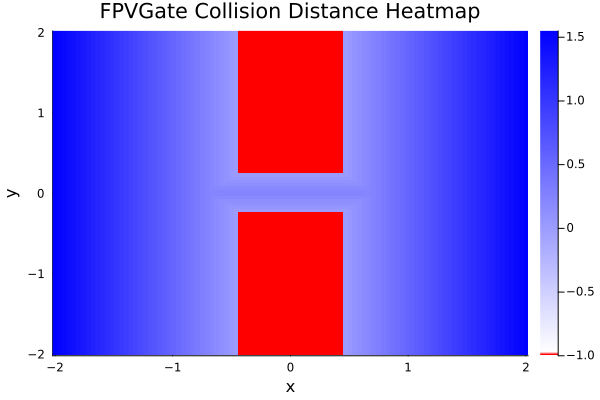

In [11]:
# Set up grid in x and y
nx, ny = 100, 100
xgrid = range(-2, 2, length=nx)
ygrid = range(-2, 2, length=ny)

# Use the FPVGate's z coordinate for all points
zval = obs_1.pos[3]  # or use your FPVGate object, e.g. obs_1

# Compute collision distance for each (x, y)
cdist = [collision_distance(obs_1, SVector(x, y, zval), 0.0) for y in ygrid, x in xgrid]
cdist_masked = [v < 0 ? -1.0 : v for v in cdist]

# Plot as heatmap
# heatmap(xgrid, ygrid, cdist, xlabel="x", ylabel="y", title="FPVGate Collision Distance Heatmap")
heatmap(
    xgrid, ygrid, cdist_masked,
    xlabel="x", ylabel="y", title="FPVGate Collision Distance Heatmap",
    color = cgrad([:red, :white, :blue], [0.0, 0.01, 1.0]), # red for collision, blue/white for safe
    clims = (-1, maximum(cdist_masked))
)

[ GatekeeperFormationFlight.Obstacles | Info ] : GatekeeperFormationFlight.Obstacles.FPVGate2D{Float64}([-2.5, 2.0, 0.35], :black)
[ GatekeeperFormationFlight.Obstacles | Info ] : Here
[ GatekeeperFormationFlight.Obstacles | Info ] : hheh
[ GatekeeperFormationFlight.Obstacles | Info ] : GatekeeperFormationFlight.Obstacles.FPVGate2D{Float64}([0.0, -2.0, 0.35], :black)
[ GatekeeperFormationFlight.Obstacles | Info ] : Here
[ GatekeeperFormationFlight.Obstacles | Info ] : hheh
[ GatekeeperFormationFlight.Obstacles | Info ] : GatekeeperFormationFlight.Obstacles.FPVGate2D{Float64}([2.5, 0.0, 0.35], :black)
[ GatekeeperFormationFlight.Obstacles | Info ] : Here
[ GatekeeperFormationFlight.Obstacles | Info ] : hheh


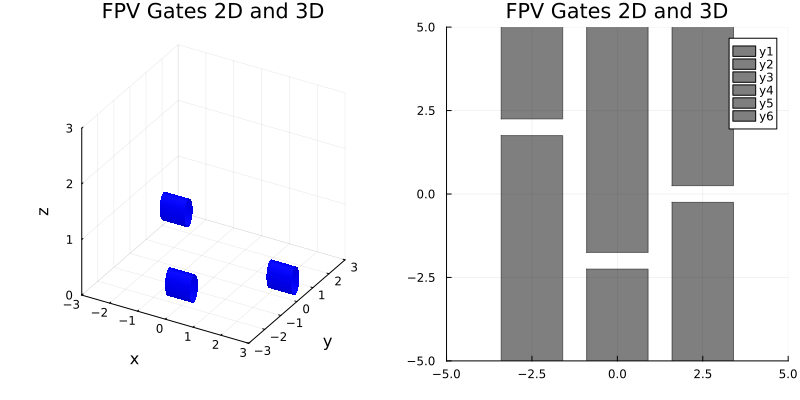

In [13]:
p = plot(label = "FPV Gates 2D")
xlims!(p, -5.0, 5.0)
ylims!(p, -5.0, 5.0)

gate_1 = FPVGate(SVector(-2.5, 2.0, 0.35))
gate_2 = FPVGate(SVector(0.0, -2.0, 0.35))
gate_3 = FPVGate(SVector(2.5, 0.0, 0.35))
plot!(get_2d_repr(gate_1))
plot!(get_2d_repr(gate_2))
plot!(get_2d_repr(gate_3))

# p3d = plot(camera = (9000, 0))
p3d = plot()
xlabel!(p3d, "x")
ylabel!(p3d, "y")
zlabel!(p3d, "z")
p3d = plot!(gate_1, label = "FPV Gate 1", linewidth = 2, color = :blue)
p3d = plot!(gate_2, label = "FPV Gate 2", linewidth = 2, color = :blue)
p3d = plot!(gate_3, label = "FPV Gate 3", linewidth = 2, color = :blue)
xlims!(p3d, -3.0, 3.0)
ylims!(p3d, -3.0, 3.0)
zlims!(p3d, 0.0, 3.0)

comb = plot(p3d, p, layout = (1, 2), size = (800, 400), title = "FPV Gates 2D and 3D")

display(comb)

## Debugging RRT W/ Gates

In [16]:
domain_min = SVector{5,Float64}(
    env.scenario.domain_min[1],
    env.scenario.domain_min[2],
    env.scenario.domain_min[3],
    -π,
    env.agent_settings.pitch_limits[1],
)
domain_max = SVector{5,Float64}(
    env.scenario.domain_max[1],
    env.scenario.domain_max[2],
    env.scenario.domain_max[3],
    π,
    env.agent_settings.pitch_limits[2],
)

rrt_domain = (domain_min, domain_max)

# Construct the rrt problem instance
rrt_problem =
    Dubins3DRRTProblem(rrt_domain, env.agent_settings.turn_radius, env.obstacles)

# Padding on the start and end states -- pre-apply the x-padding
x0 = @SVector [
    env.scenario.start_pose[1] + env.agent_settings.x_padding,
    env.scenario.start_pose[2],
    env.scenario.start_pose[3],
    env.scenario.start_pose[4],
    env.scenario.start_pose[5],
]

xg = @SVector [
    env.scenario.goal_pose[1] - env.agent_settings.x_padding,
    env.scenario.goal_pose[2],
    env.scenario.goal_pose[3],
    env.scenario.goal_pose[4],
    env.scenario.goal_pose[5],
]

nodes = [Node(x0)]
nodes = rrt_star(rrt_problem, nodes, 500)


500-element Vector{Node{SVector{5, Float64}}}:
 Node{SVector{5, Float64}}([-1.7, -1.2, 0.5, 0.0, 0.0], 0, 0.0)
 Node{SVector{5, Float64}}([-1.1516751896870947, 1.9369258889671166, 0.429292231625243, 1.9304604380836794, -0.6085465685498106], 342, 1.4456722172045042)
 Node{SVector{5, Float64}}([-0.4533496566238251, 0.8950324055234147, 0.3857454075854053, 1.4805546809254435, -0.01312102823254182], 1, 2.695508499632249)
 Node{SVector{5, Float64}}([-2.1708899522986678, 1.502793292205112, 0.7206391604806679, -3.059646007631744, 0.30769066801876566], 338, 1.8143536043003627)
 Node{SVector{5, Float64}}([-1.3347398449964492, 0.9000734041905909, 1.6862524068945337, 2.8181248870109443, 0.5386464531290358], 1, 3.2875451023483246)
 Node{SVector{5, Float64}}([-0.8791510583003458, 1.486963557535865, 0.6996574369001309, 1.757459443626226, -0.5439267893008488], 1, 3.489959537336732)
 Node{SVector{5, Float64}}([-1.9441329406713876, 1.7133131772894774, 0.7468543294997572, 2.9065737799213576, 0.1087677449

### Plot all the sampled nodes in 2D, with the gate

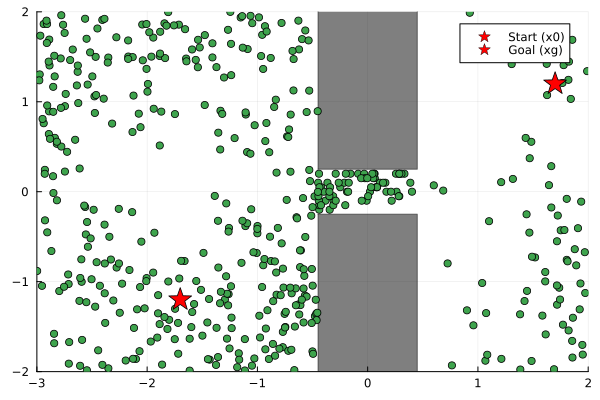

[ GatekeeperFormationFlight.Obstacles | Info ] : GatekeeperFormationFlight.Obstacles.FPVGate2D{Float64}([0.0, 0.0, 0.5], :black)
[ GatekeeperFormationFlight.Obstacles | Info ] : Here
[ GatekeeperFormationFlight.Obstacles | Info ] : hheh


In [19]:
p = plot()

for obs in env.obstacles
    plot!(get_2d_repr(obs), label = false)
    # plot!(obs, label = false, linewidth = 2)
end

# Plot the RRT nodes in 2D
xs = [node.state[1] for node in nodes]
ys = [node.state[2] for node in nodes]
# zs = [node.state[3] for node in nodes]

scatter!(xs, ys, label=false)

xlims!(p, env.scenario.domain_min[1], env.scenario.domain_max[1])
ylims!(p, env.scenario.domain_min[2], env.scenario.domain_max[2])
zlims!(p, env.scenario.domain_min[3], env.scenario.domain_max[3])


# plot the start and goal poses as stars
scatter!(p, [x0[1]], [x0[2]], color=:red, marker=:star5, markersize=12, label="Start (x0)")
scatter!(p, [xg[1]], [xg[2]], color=:red, marker=:star5, markersize=12, label="Goal (xg)")

display(p)

In [20]:
success, waypoints = get_best_path(rrt_problem, nodes, xg)

(true, SVector{5, Float64}[[-1.7, -1.2, 0.5, 0.0, 0.0], [-0.8924476573870501, 0.4387271275154072, 0.48208023145503603, 2.168697296893601, 0.03758418711333083], [-0.2029146516905288, -0.15000000000000008, 0.3999999999999997, 0.05507505683580243, -0.07593314362201055], [1.7, 1.2, 0.5, 0.0, 0.0]])

In [18]:
@show xg

xg = [1.7, 1.2, 1.5, 0.0, 0.0]


5-element SVector{5, Float64} with indices SOneTo(5):
 1.7
 1.2
 1.5
 0.0
 0.0